## LSTM for time-series forecasting on water flow data gathered by the Karachi Water Project

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scienceplots
import os

plt.style.use(['science','ieee'])

c:\Users\akeel\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_data(n):
  url = "data_v9_flow_cleaned.csv"
  if n != None:
    df_raw = pd.read_csv(url, nrows=n)
  else:    
    df_raw = pd.read_csv(url)
  return df_raw


## 5 Min Volume+Temp

In [3]:
def five_min_window(df_raw, scaler):
  df1 = df_raw.groupby(df_raw['5min_count']).sum().reset_index()
  df2 = df_raw.groupby(df_raw['5min_count']).mean().reset_index()
  df1 = df1.loc[:,["volume"]]
  df1 = scaler.fit_transform(df1)
  df1 = pd.DataFrame(df1, columns = ["volume"])
  df2 = df2.loc[:,["temp"]]
  df = pd.concat([df1, df2], axis=1, join='inner')
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 12
  stride = 2

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i][0]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [4]:
df_raw = read_data(n=None)

In [5]:
scaler = StandardScaler() 
train_data, test_data, scaler = five_min_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
10000 / 65576
20000 / 65576
30000 / 65576
40000 / 65576
50000 / 65576
60000 / 65576
3. Completed


In [6]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
26/26 [==============================] - 32s 301ms/step - loss: 1.1220 - mean_squared_error: 1.1220 - val_loss: 1.7160 - val_mean_squared_error: 1.7160
Epoch 2/100
26/26 [==============================] - 2s 92ms/step - loss: 0.8354 - mean_squared_error: 0.8354 - val_loss: 1.7136 - val_mean_squared_error: 1.7136
Epoch 3/100
26/26 [==============================] - 3s 120ms/step - loss: 0.8086 - mean_squared_error: 0.8086 - val_loss: 1.7029 - val_mean_squared_error: 1.7029
Epoch 4/100
26/26 [==============================] - 4s 165ms/step - loss: 0.8335 - mean_squared_error: 0.8335 - val_loss: 1.7235 - val_mean_squared_error: 1.7235
Epoch 5/100
26/26 [==============================] - 3s 116ms/step - loss: 0.8033 - mean_squared_error: 0.8033 - val_loss: 1.6811 - val_mean_squared_error: 1.6811
Epoch 6/100
26/26 [==============================] - 2s 85ms/step - loss: 0.8096 - mean_squared_error: 0.8096 - val_loss: 1.8287 - val_mean_squared_error: 1.8287
Epoch 7/100
26/26 [====

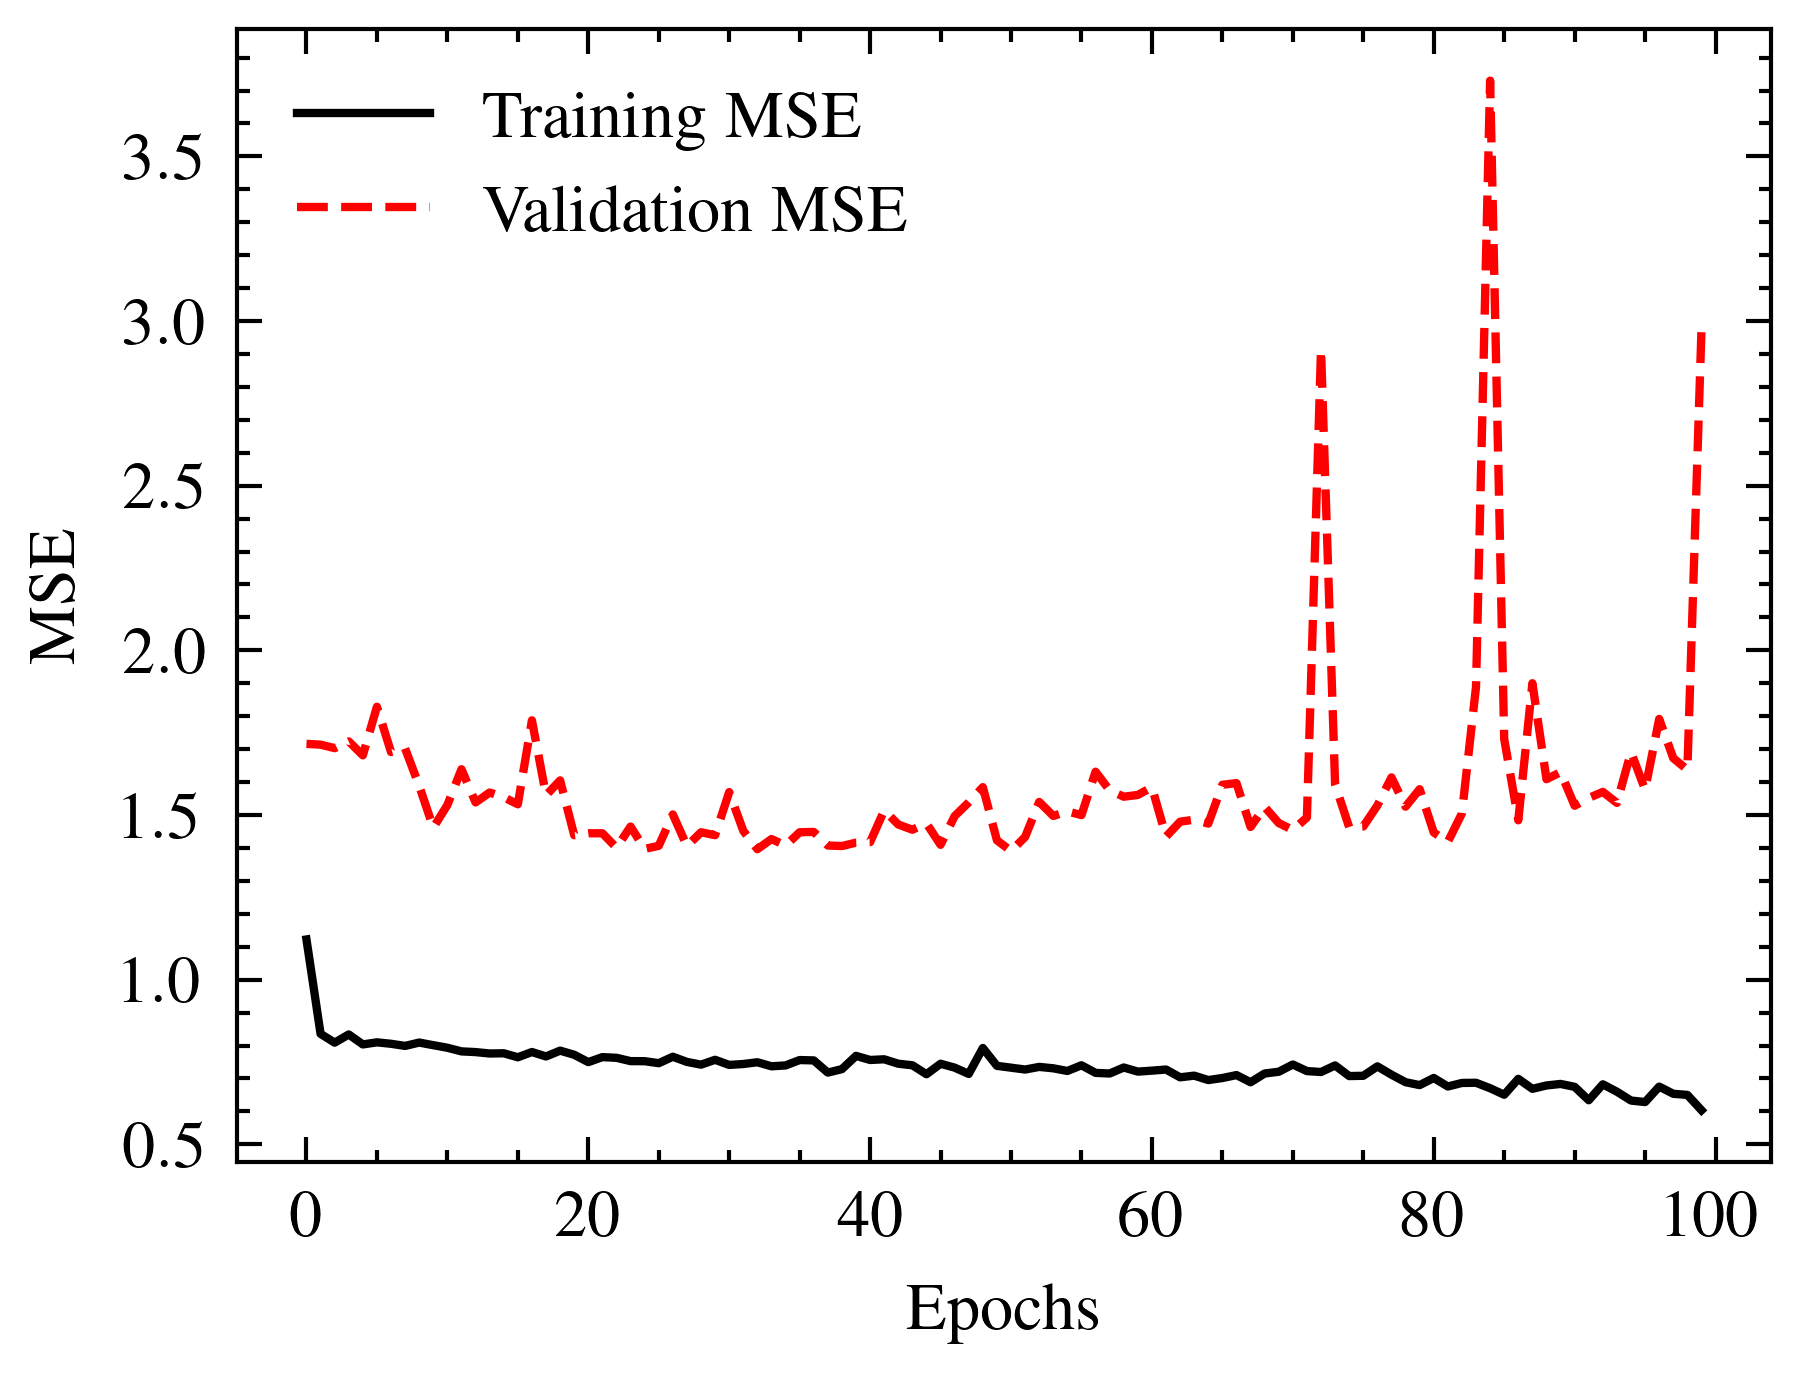

In [7]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 

NUM_EPOCHS = 100
BATCH_SIZE = 256

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

205/205 [==============================] - 8s 18ms/step


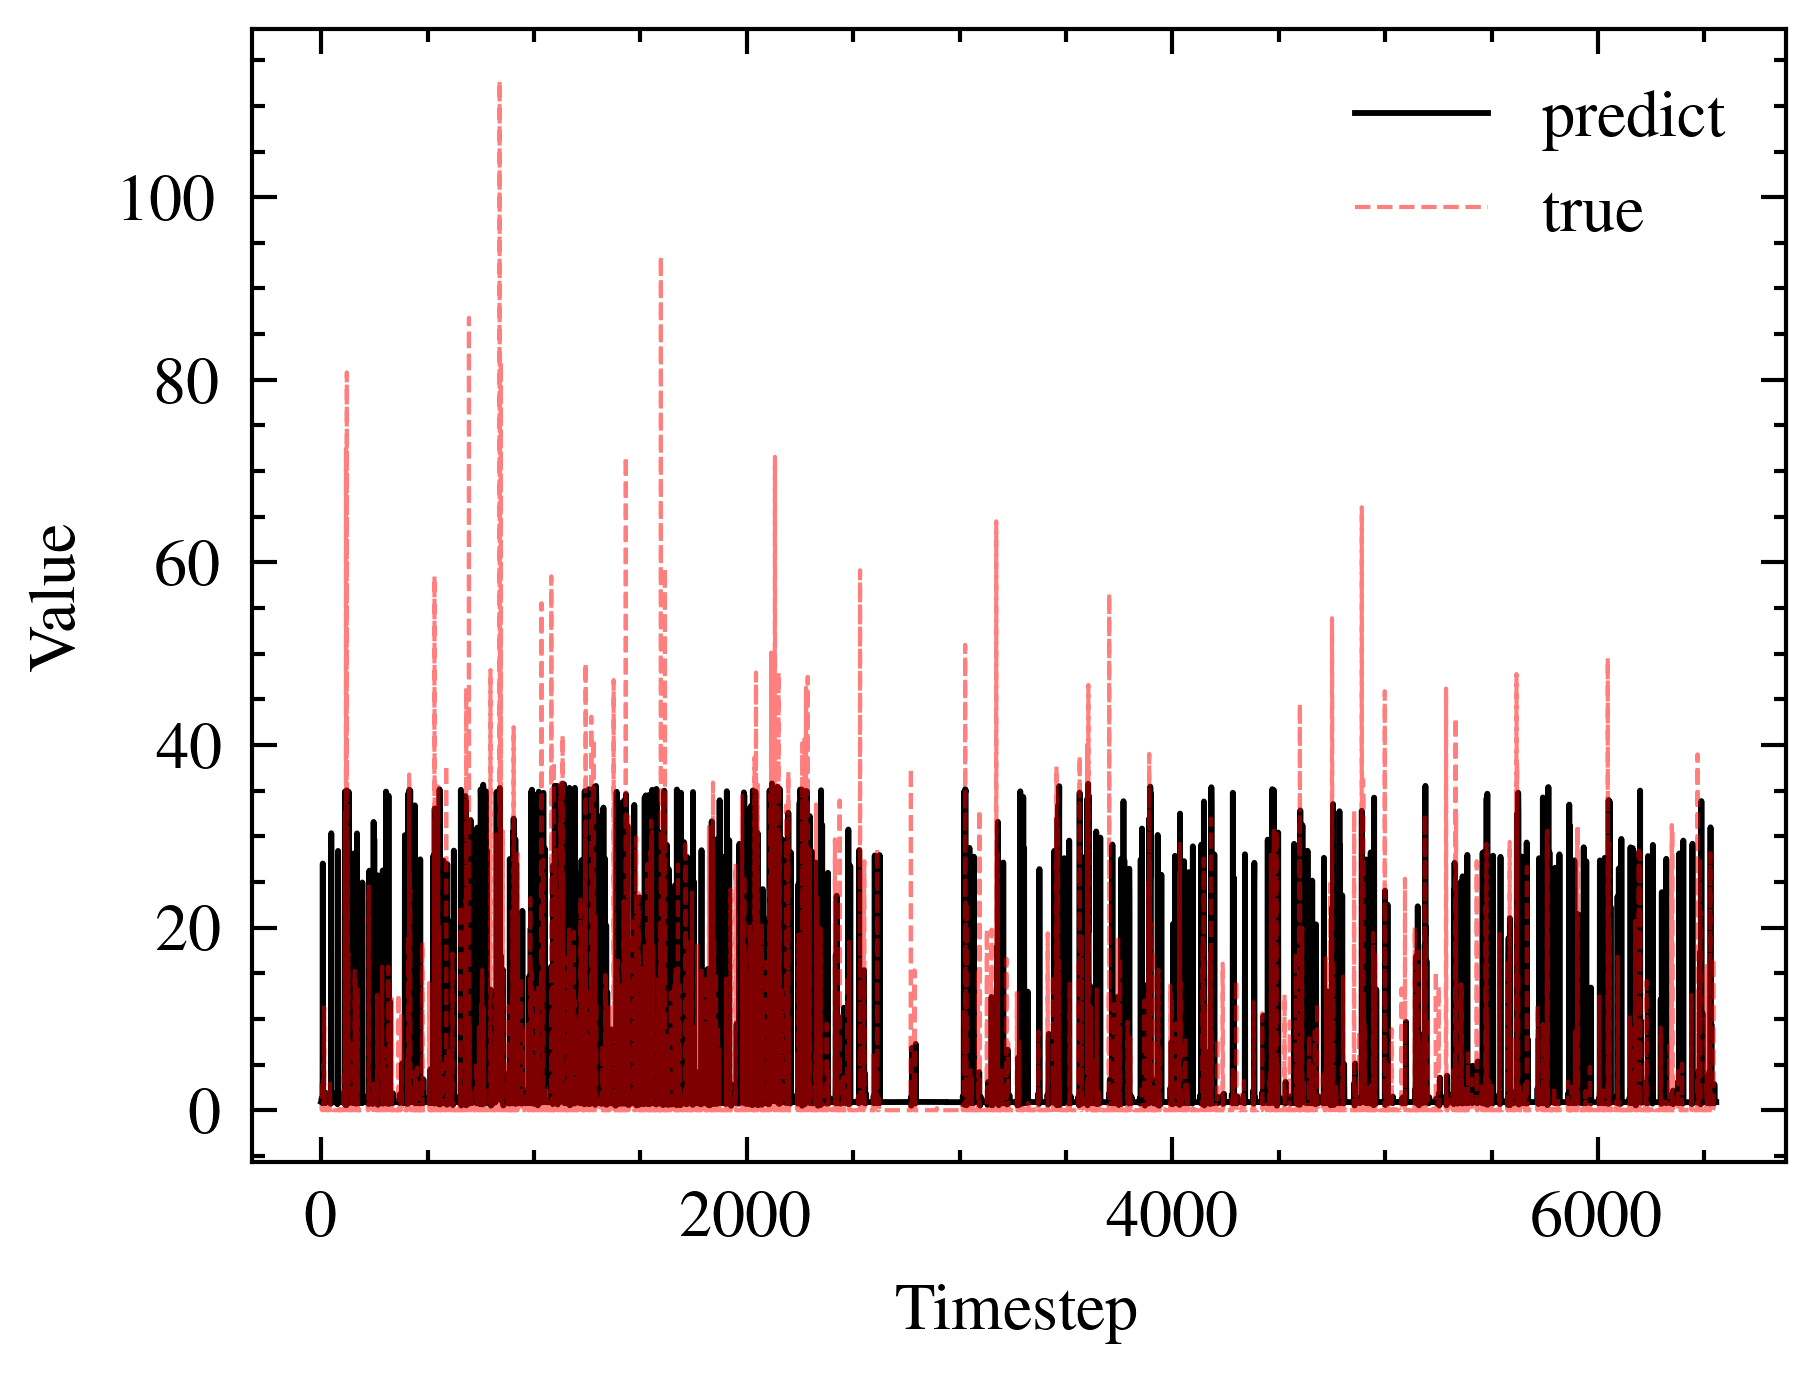

In [8]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels.reshape((-1, 1)))
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# 30 Minute Volume+Temp

In [9]:
def thirty_min_window(df_raw, scaler):
  df1 = df_raw.groupby(df_raw['30min_count']).sum().reset_index()
  df2 = df_raw.groupby(df_raw['30min_count']).mean().reset_index()
  df1 = df1.loc[:,["volume"]]
  df1 = scaler.fit_transform(df1)
  df1 = pd.DataFrame(df1, columns = ["volume"])
  df2 = df2.loc[:,["temp"]]
  df = pd.concat([df1, df2], axis=1, join='inner')
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 24
  stride = 6

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i][0]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [10]:
df_raw = read_data(n=None)

In [11]:
scaler = StandardScaler() 
train_data, test_data, scaler = thirty_min_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


In [12]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
19/19 [==============================] - 26s 335ms/step - loss: 1.1075 - mean_squared_error: 1.1075 - val_loss: 1.7692 - val_mean_squared_error: 1.7692
Epoch 2/100
19/19 [==============================] - 1s 76ms/step - loss: 0.9136 - mean_squared_error: 0.9136 - val_loss: 1.7799 - val_mean_squared_error: 1.7799
Epoch 3/100
19/19 [==============================] - 1s 76ms/step - loss: 0.8903 - mean_squared_error: 0.8903 - val_loss: 1.7682 - val_mean_squared_error: 1.7682
Epoch 4/100
19/19 [==============================] - 1s 80ms/step - loss: 0.8066 - mean_squared_error: 0.8066 - val_loss: 1.7673 - val_mean_squared_error: 1.7673
Epoch 5/100
19/19 [==============================] - 1s 80ms/step - loss: 0.7652 - mean_squared_error: 0.7652 - val_loss: 1.8716 - val_mean_squared_error: 1.8716
Epoch 6/100
19/19 [==============================] - 1s 77ms/step - loss: 0.7973 - mean_squared_error: 0.7973 - val_loss: 1.8127 - val_mean_squared_error: 1.8127
Epoch 7/100
19/19 [=======

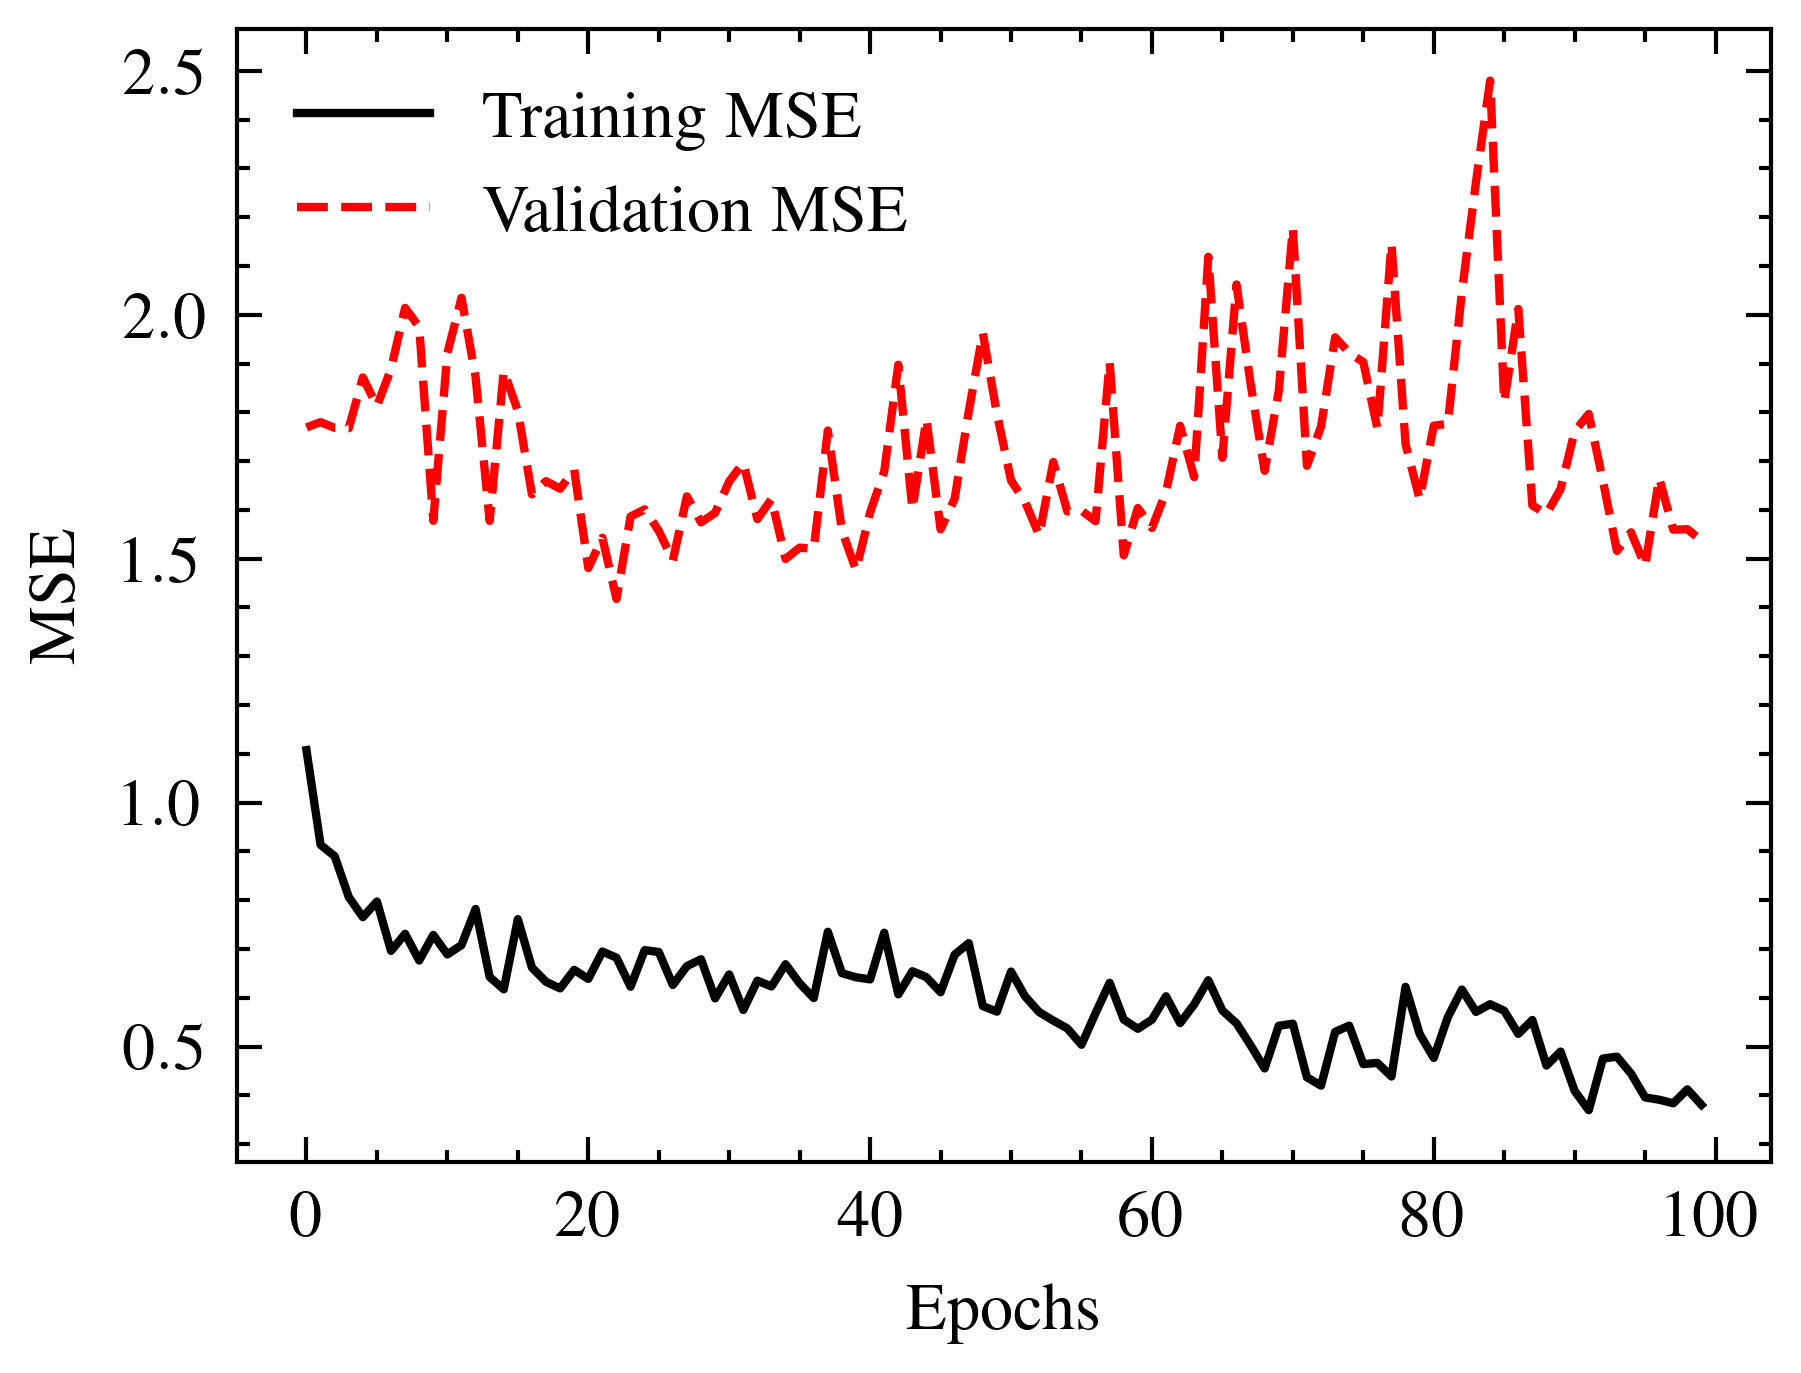

In [13]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 


NUM_EPOCHS = 100
BATCH_SIZE = 20

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

12/12 [==============================] - 4s 36ms/step


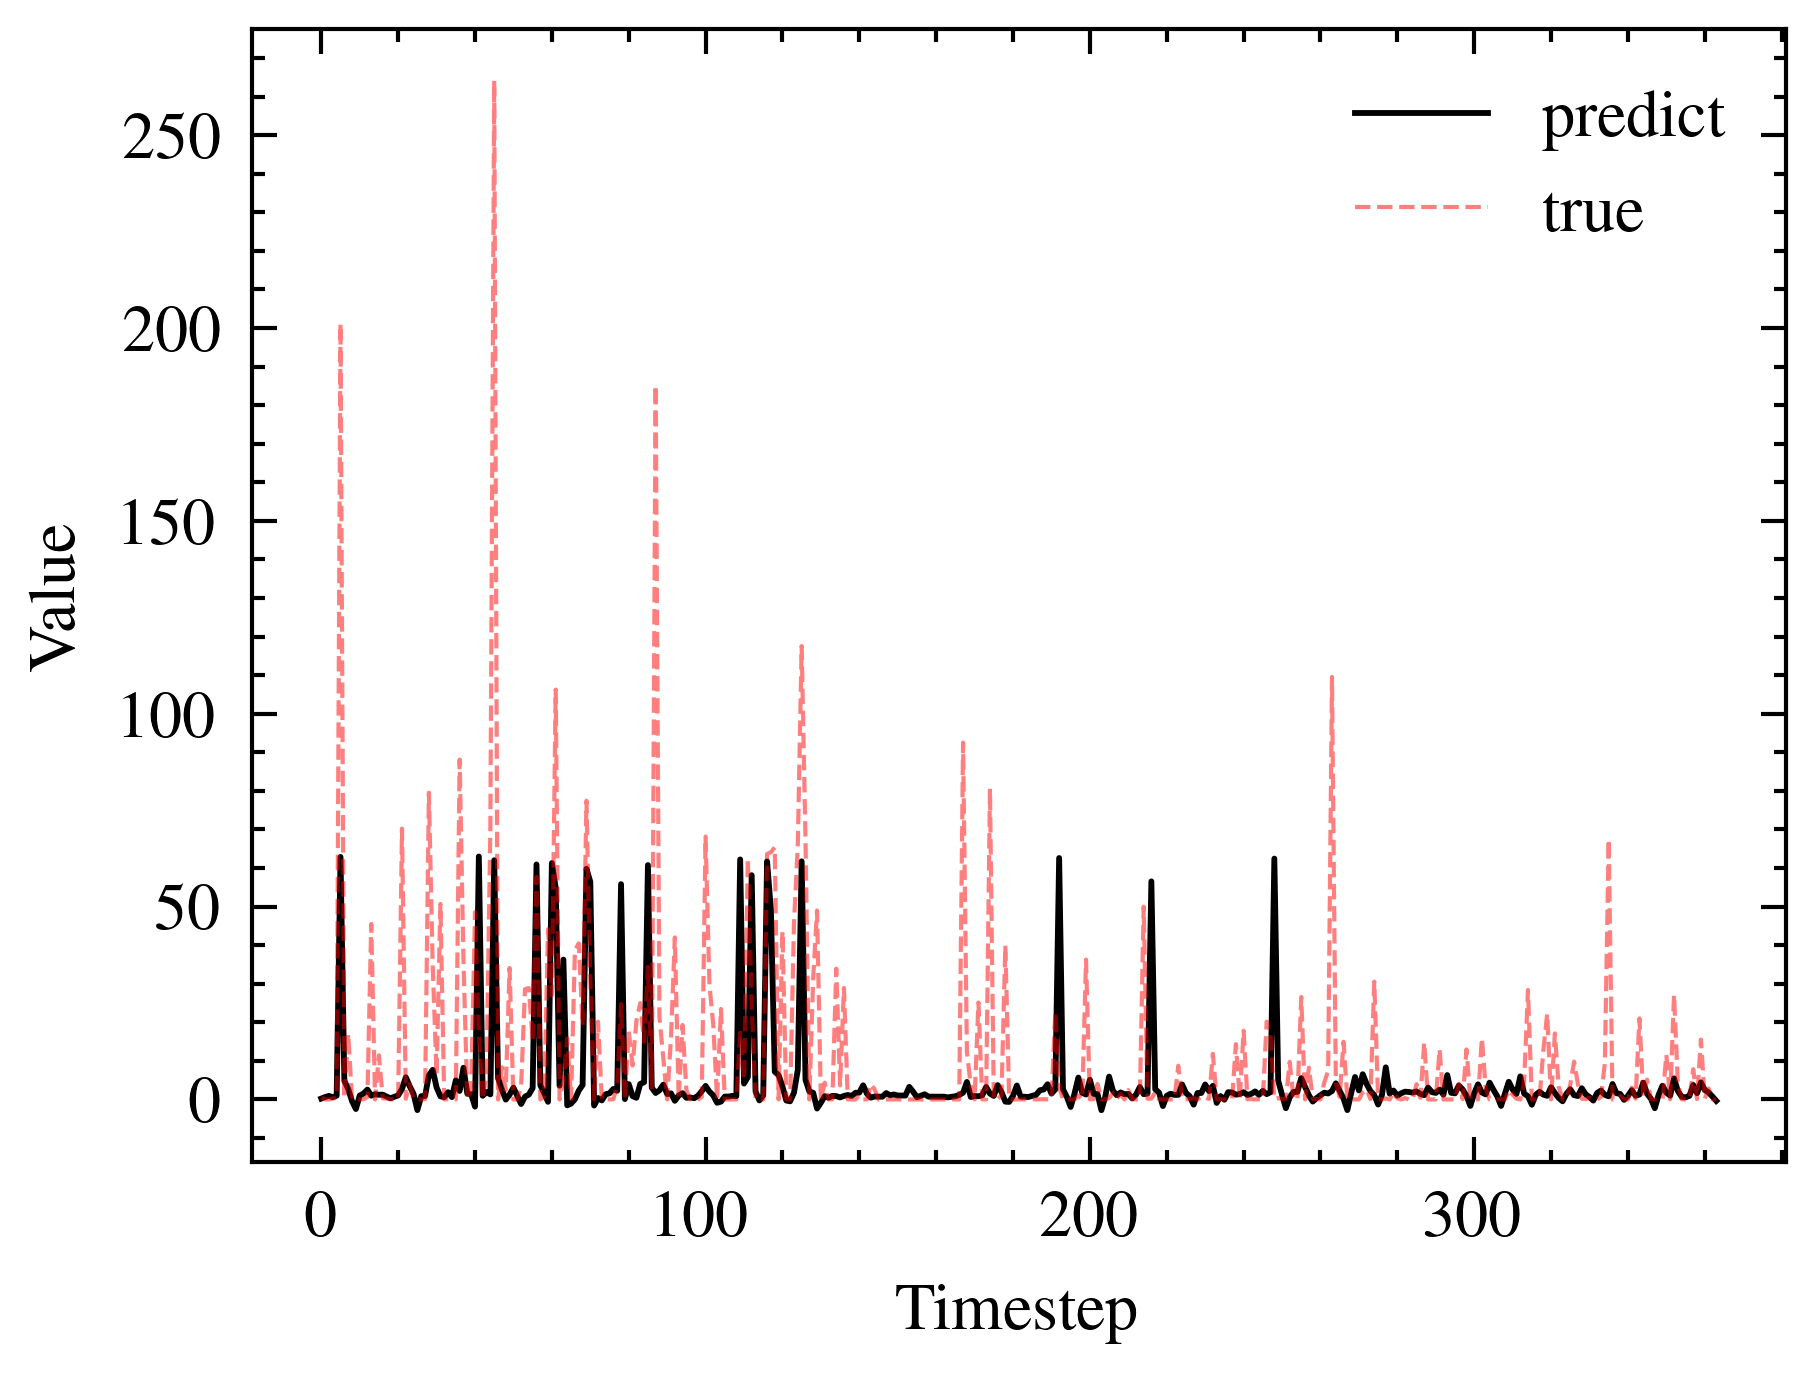

In [14]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels.reshape((-1, 1)))
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# One Hour Volume+Temp

In [15]:
def one_hour_window(df_raw, scaler):
  df1 = df_raw.groupby(df_raw['hour_count']).sum().reset_index()
  df2 = df_raw.groupby(df_raw['hour_count']).mean().reset_index()
  df1 = df1.loc[:,["volume"]]
  df1 = scaler.fit_transform(df1)
  df1 = pd.DataFrame(df1, columns = ["volume"])
  df2 = df2.loc[:,["temp"]]
  df = pd.concat([df1, df2], axis=1, join='inner')
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 24
  stride = 6

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i][0]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [16]:
df_raw = read_data(n=None)

In [17]:
scaler = StandardScaler() 
train_data, test_data, scaler = one_hour_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


In [18]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
37/37 [==============================] - 29s 217ms/step - loss: 1.6244 - mean_squared_error: 1.6244 - val_loss: 3.1404 - val_mean_squared_error: 3.1404
Epoch 2/100
37/37 [==============================] - 3s 76ms/step - loss: 1.5339 - mean_squared_error: 1.5339 - val_loss: 3.1510 - val_mean_squared_error: 3.1510
Epoch 3/100
37/37 [==============================] - 3s 77ms/step - loss: 1.5703 - mean_squared_error: 1.5703 - val_loss: 3.1433 - val_mean_squared_error: 3.1433
Epoch 4/100
37/37 [==============================] - 3s 78ms/step - loss: 1.4792 - mean_squared_error: 1.4792 - val_loss: 3.2659 - val_mean_squared_error: 3.2659
Epoch 5/100
37/37 [==============================] - 3s 81ms/step - loss: 1.4665 - mean_squared_error: 1.4665 - val_loss: 3.2916 - val_mean_squared_error: 3.2916
Epoch 6/100
37/37 [==============================] - 3s 78ms/step - loss: 1.4726 - mean_squared_error: 1.4726 - val_loss: 3.1355 - val_mean_squared_error: 3.1355
Epoch 7/100
37/37 [=======

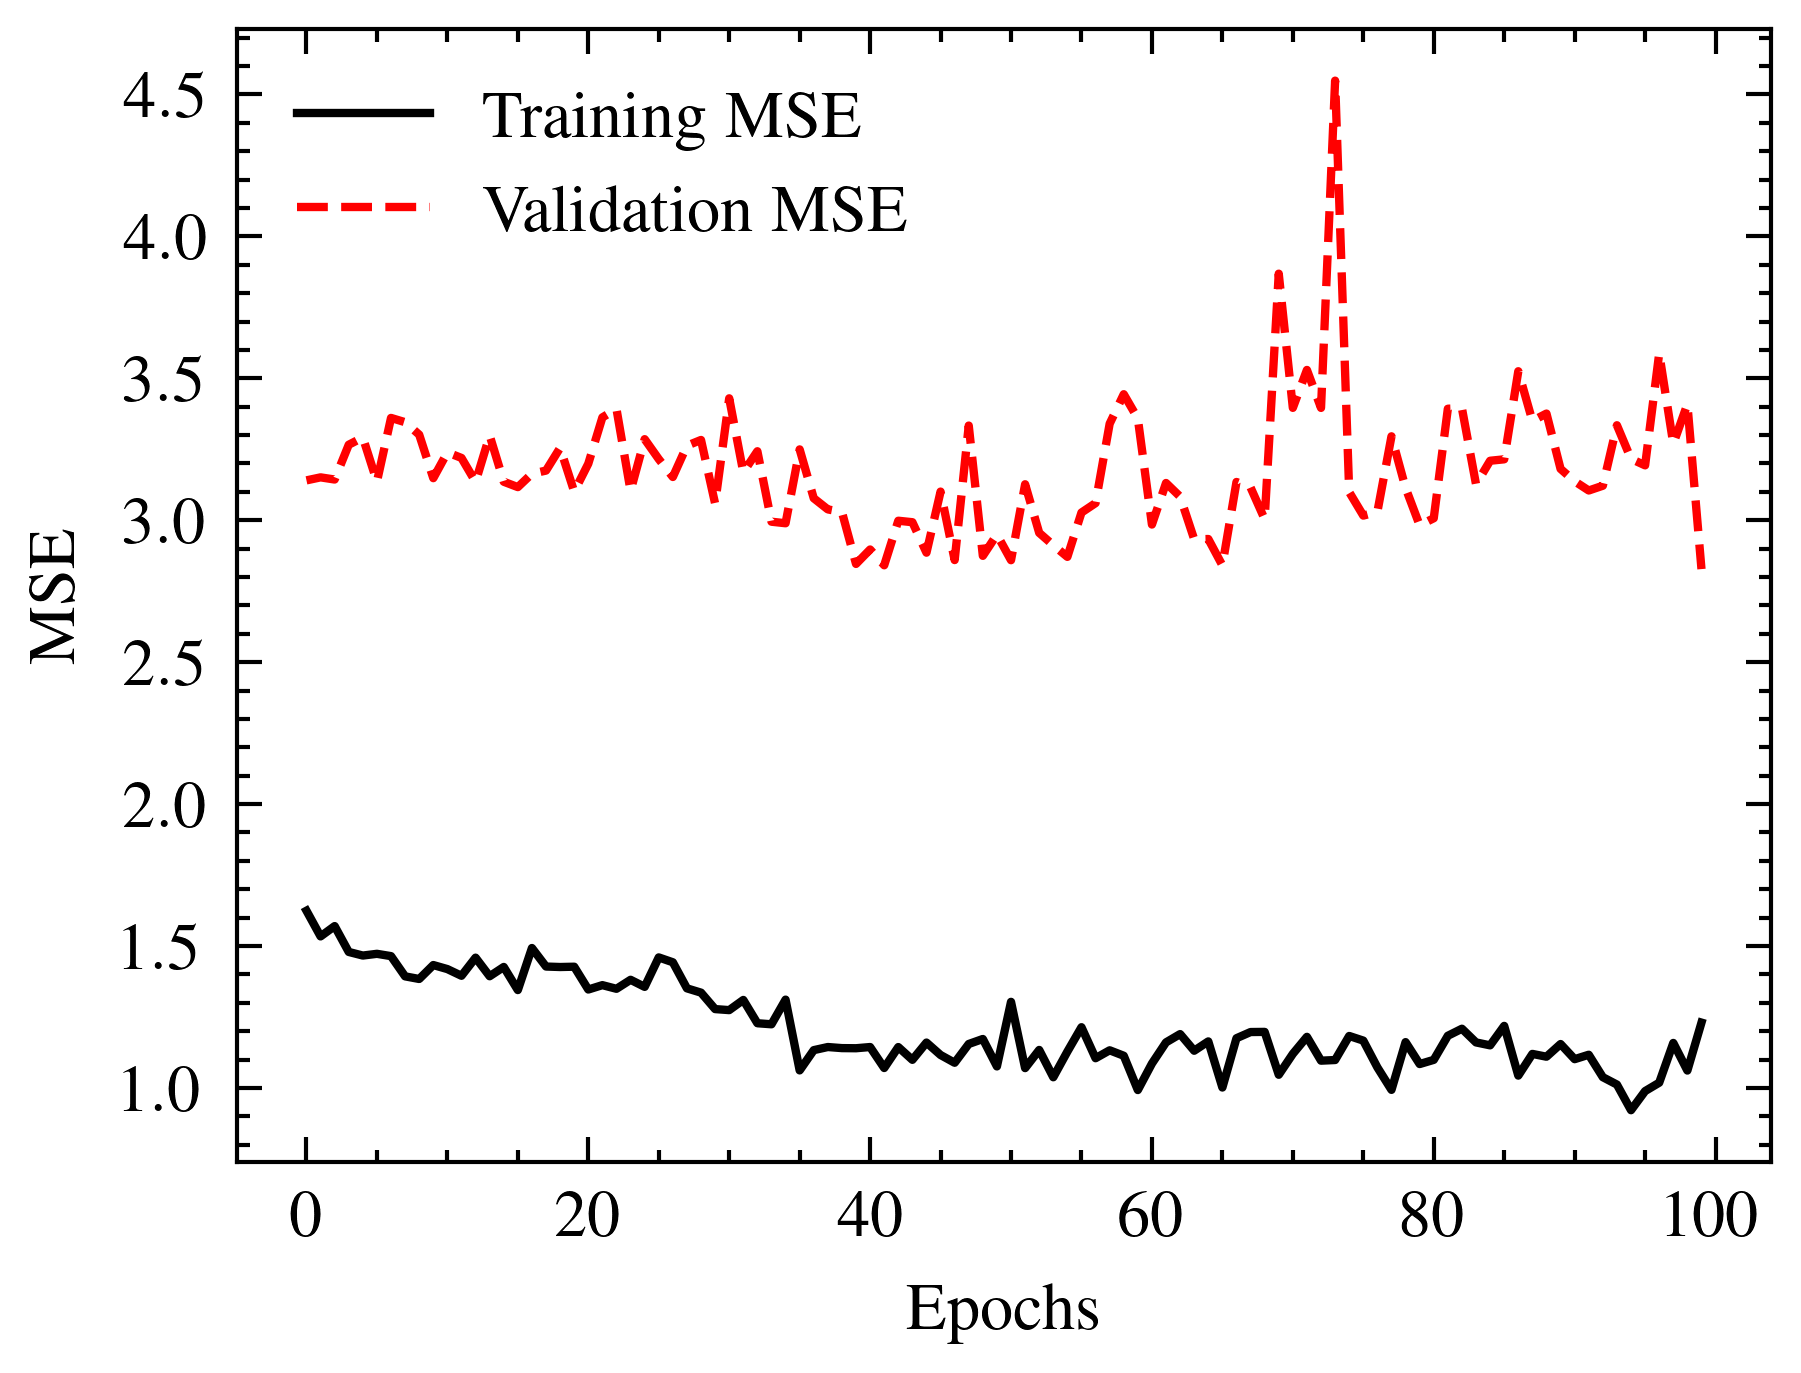

In [19]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 


NUM_EPOCHS = 100
BATCH_SIZE = 5

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

6/6 [==============================] - 4s 47ms/step


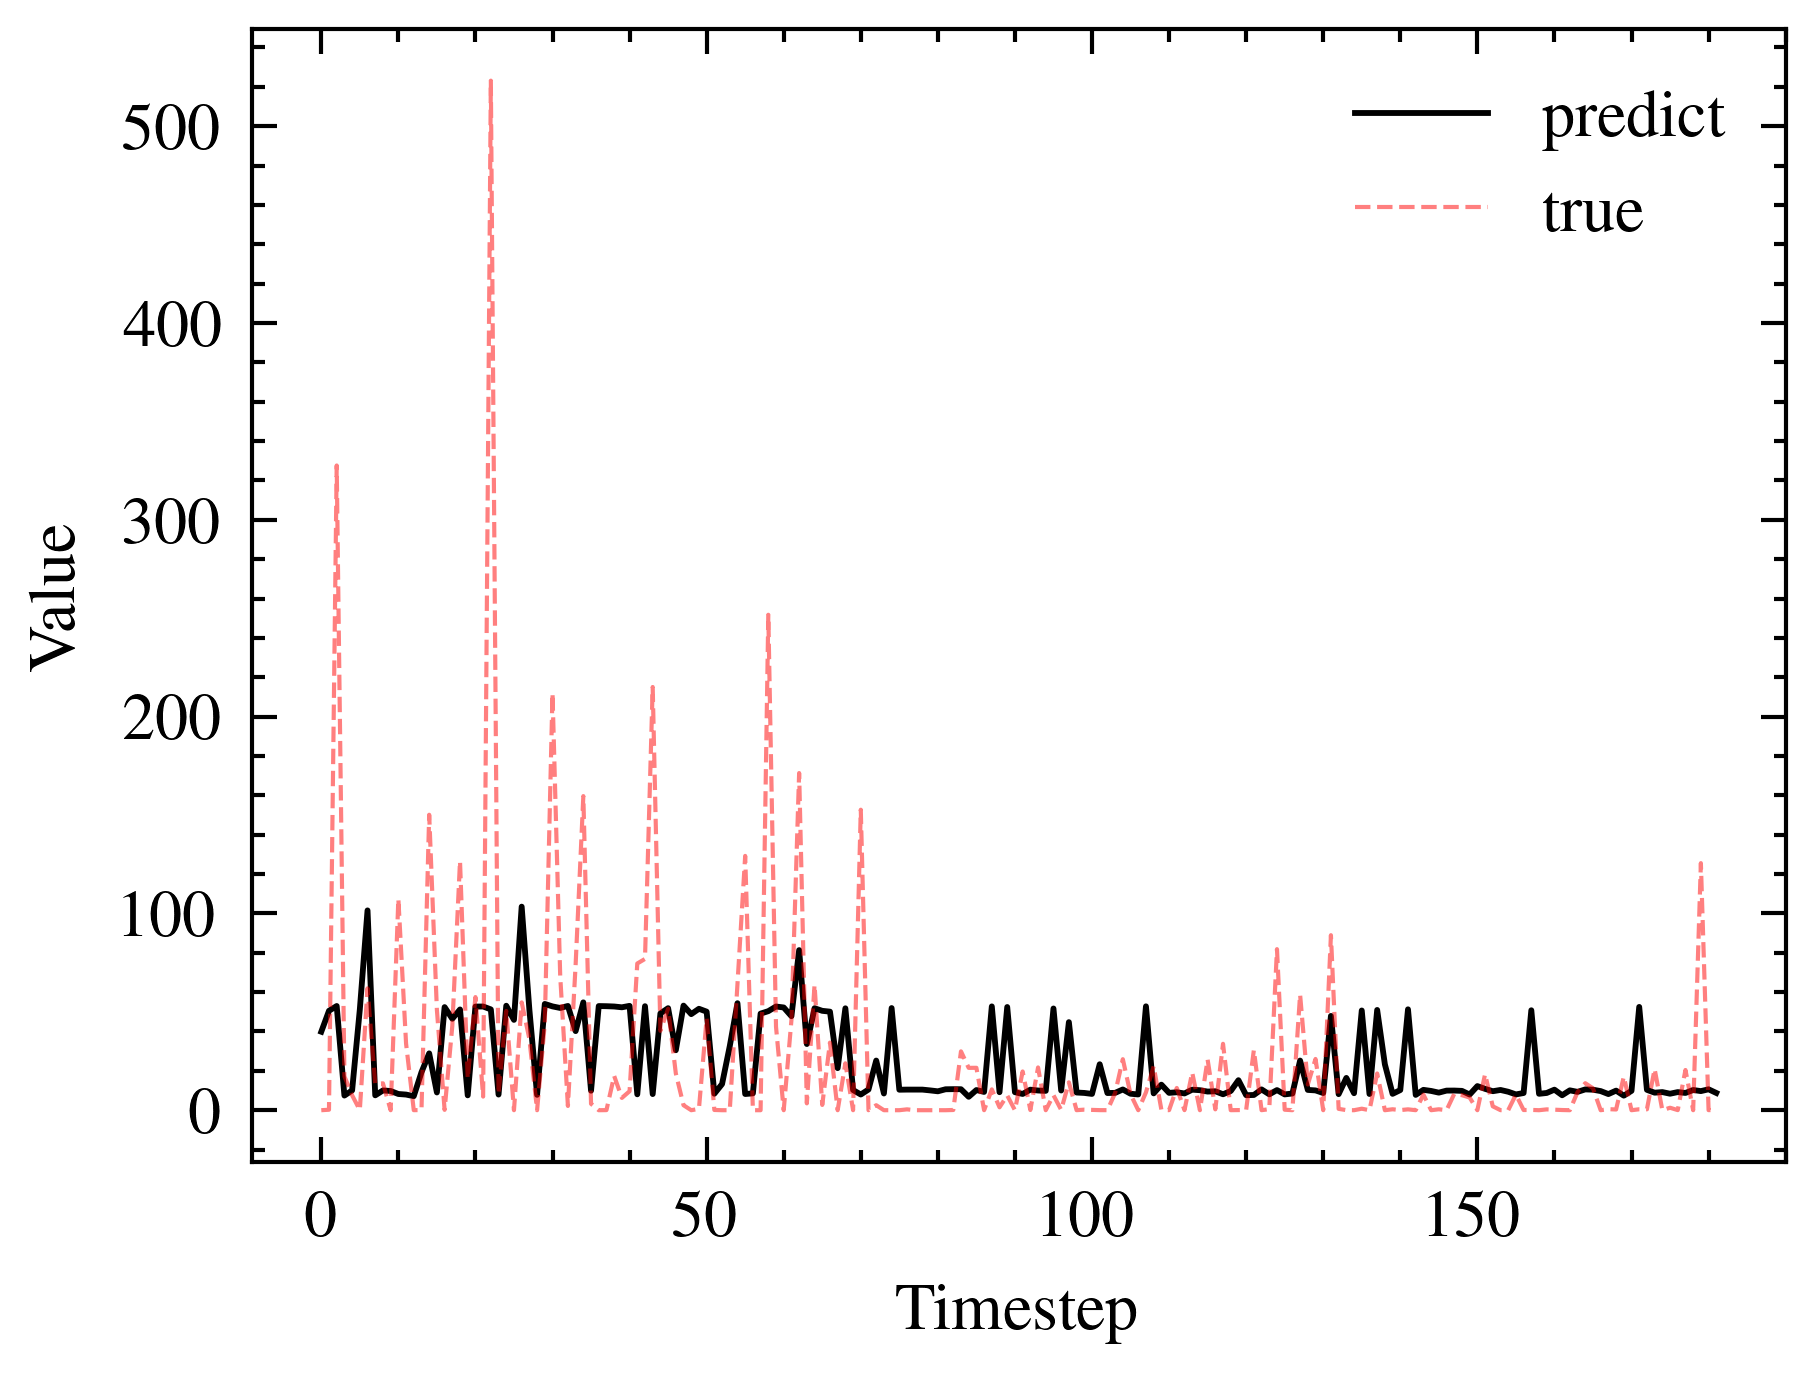

In [20]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels.reshape((-1, 1)))
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# One Week Volume+Temp

In [21]:
def one_week_window(df_raw, scaler):
  df1 = df_raw.groupby(df_raw['week_count']).sum().reset_index()
  df2 = df_raw.groupby(df_raw['week_count']).mean().reset_index()
  df1 = df1.loc[:,["volume"]]
  df1 = scaler.fit_transform(df1)
  df1 = pd.DataFrame(df1, columns = ["volume"])
  df2 = df2.loc[:,["temp"]]
  df = pd.concat([df1, df2], axis=1, join='inner')
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 4
  stride = 1

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i][0]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [22]:
df_raw = read_data(n=None)

In [23]:
scaler = StandardScaler() 
train_data, test_data, scaler = one_week_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


In [24]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/50
6/6 [==============================] - 22s 874ms/step - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 2.6471 - val_mean_squared_error: 2.6471
Epoch 2/50
6/6 [==============================] - 0s 61ms/step - loss: 0.2383 - mean_squared_error: 0.2383 - val_loss: 2.7244 - val_mean_squared_error: 2.7244
Epoch 3/50
6/6 [==============================] - 0s 56ms/step - loss: 0.3676 - mean_squared_error: 0.3676 - val_loss: 2.7825 - val_mean_squared_error: 2.7825
Epoch 4/50
6/6 [==============================] - 0s 57ms/step - loss: 0.6030 - mean_squared_error: 0.6030 - val_loss: 2.7436 - val_mean_squared_error: 2.7436
Epoch 5/50
6/6 [==============================] - 0s 55ms/step - loss: 0.3174 - mean_squared_error: 0.3174 - val_loss: 2.8316 - val_mean_squared_error: 2.8316
Epoch 6/50
6/6 [==============================] - 0s 55ms/step - loss: 0.2128 - mean_squared_error: 0.2128 - val_loss: 2.8755 - val_mean_squared_error: 2.8755
Epoch 7/50
6/6 [============================

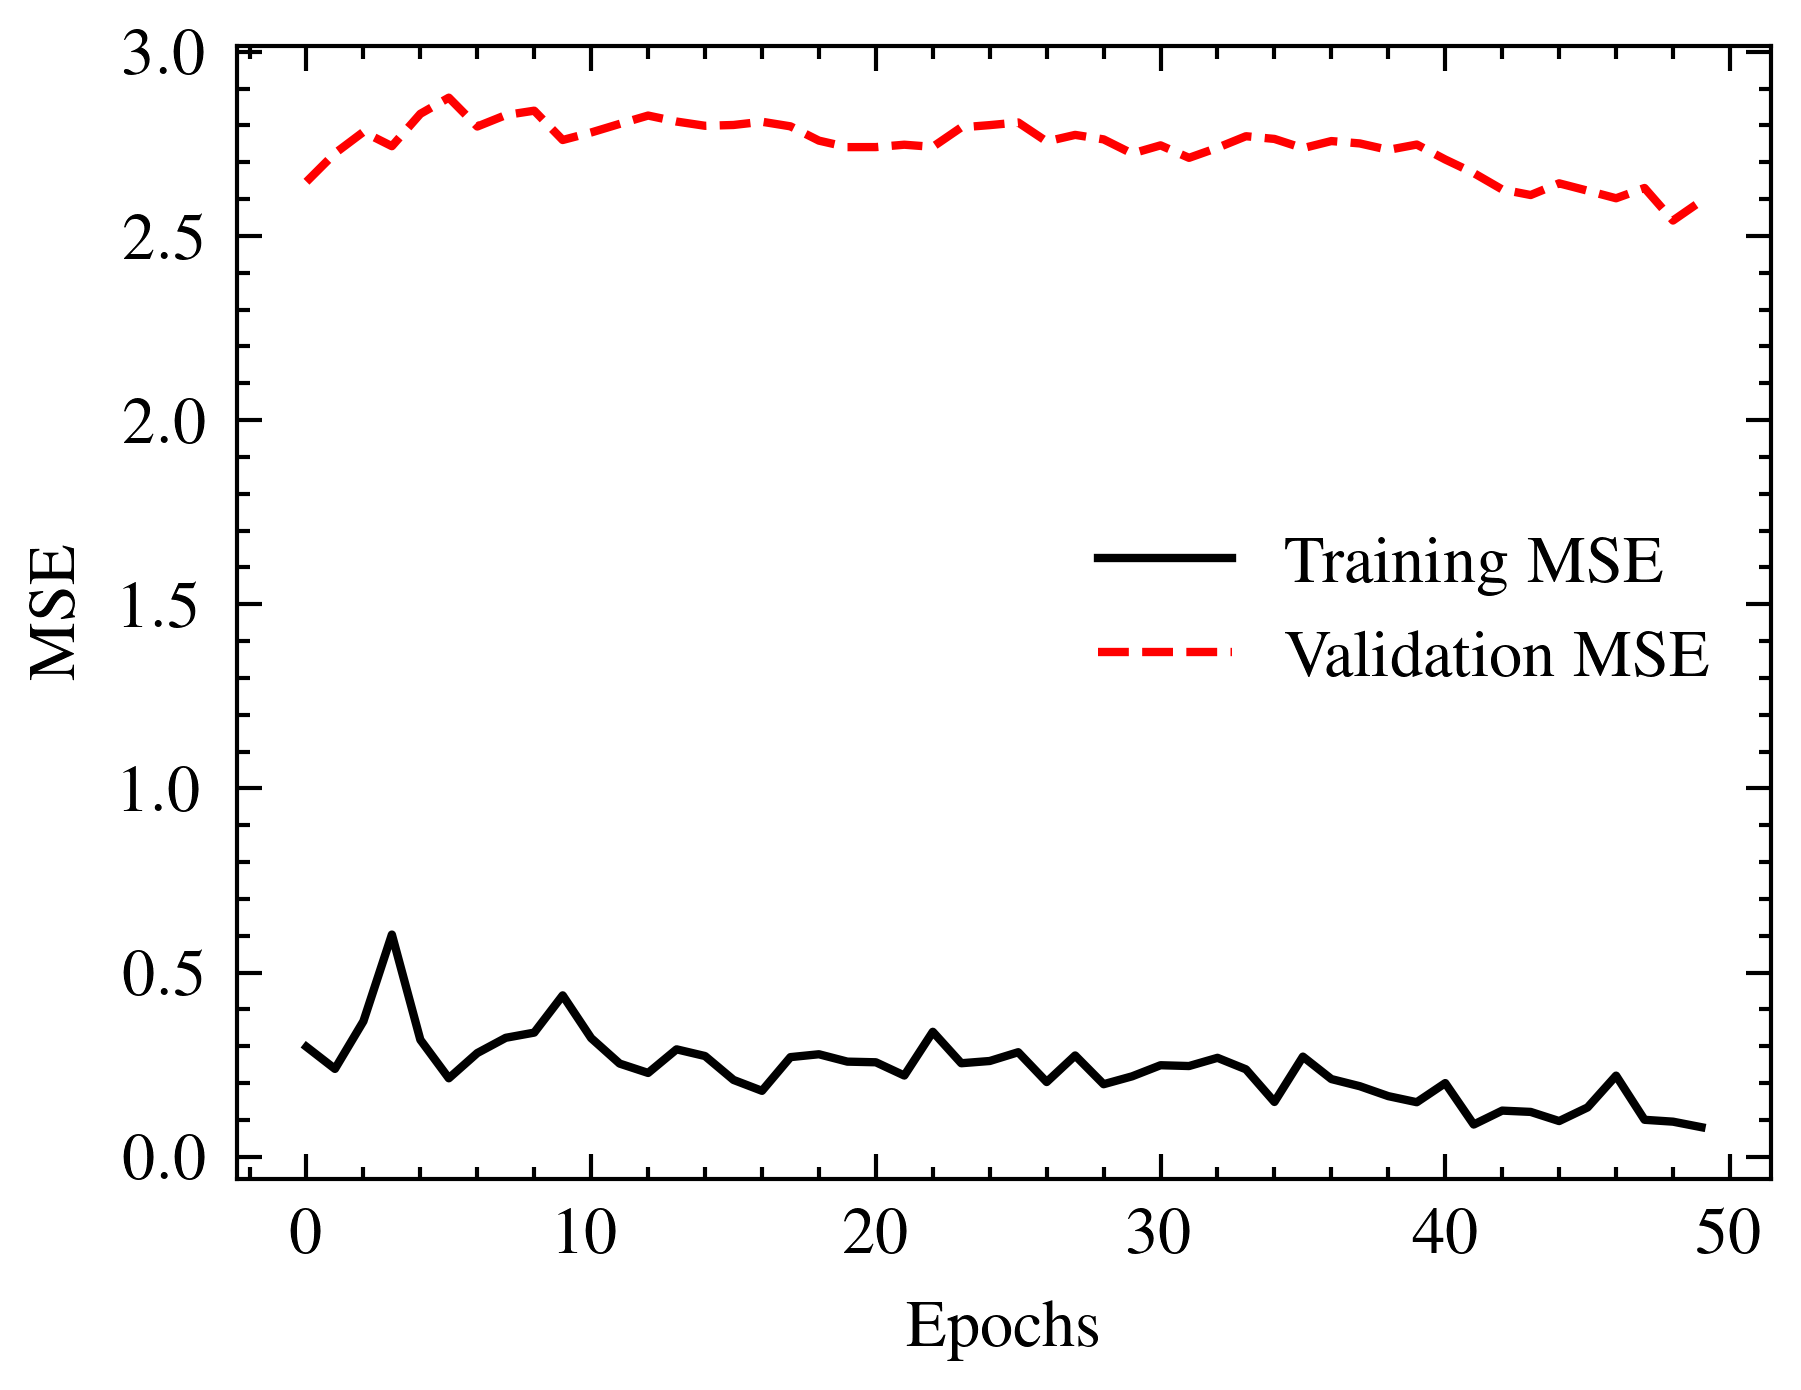

In [25]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 


NUM_EPOCHS = 50
BATCH_SIZE = 1

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

1/1 [==============================] - 8s 8s/step


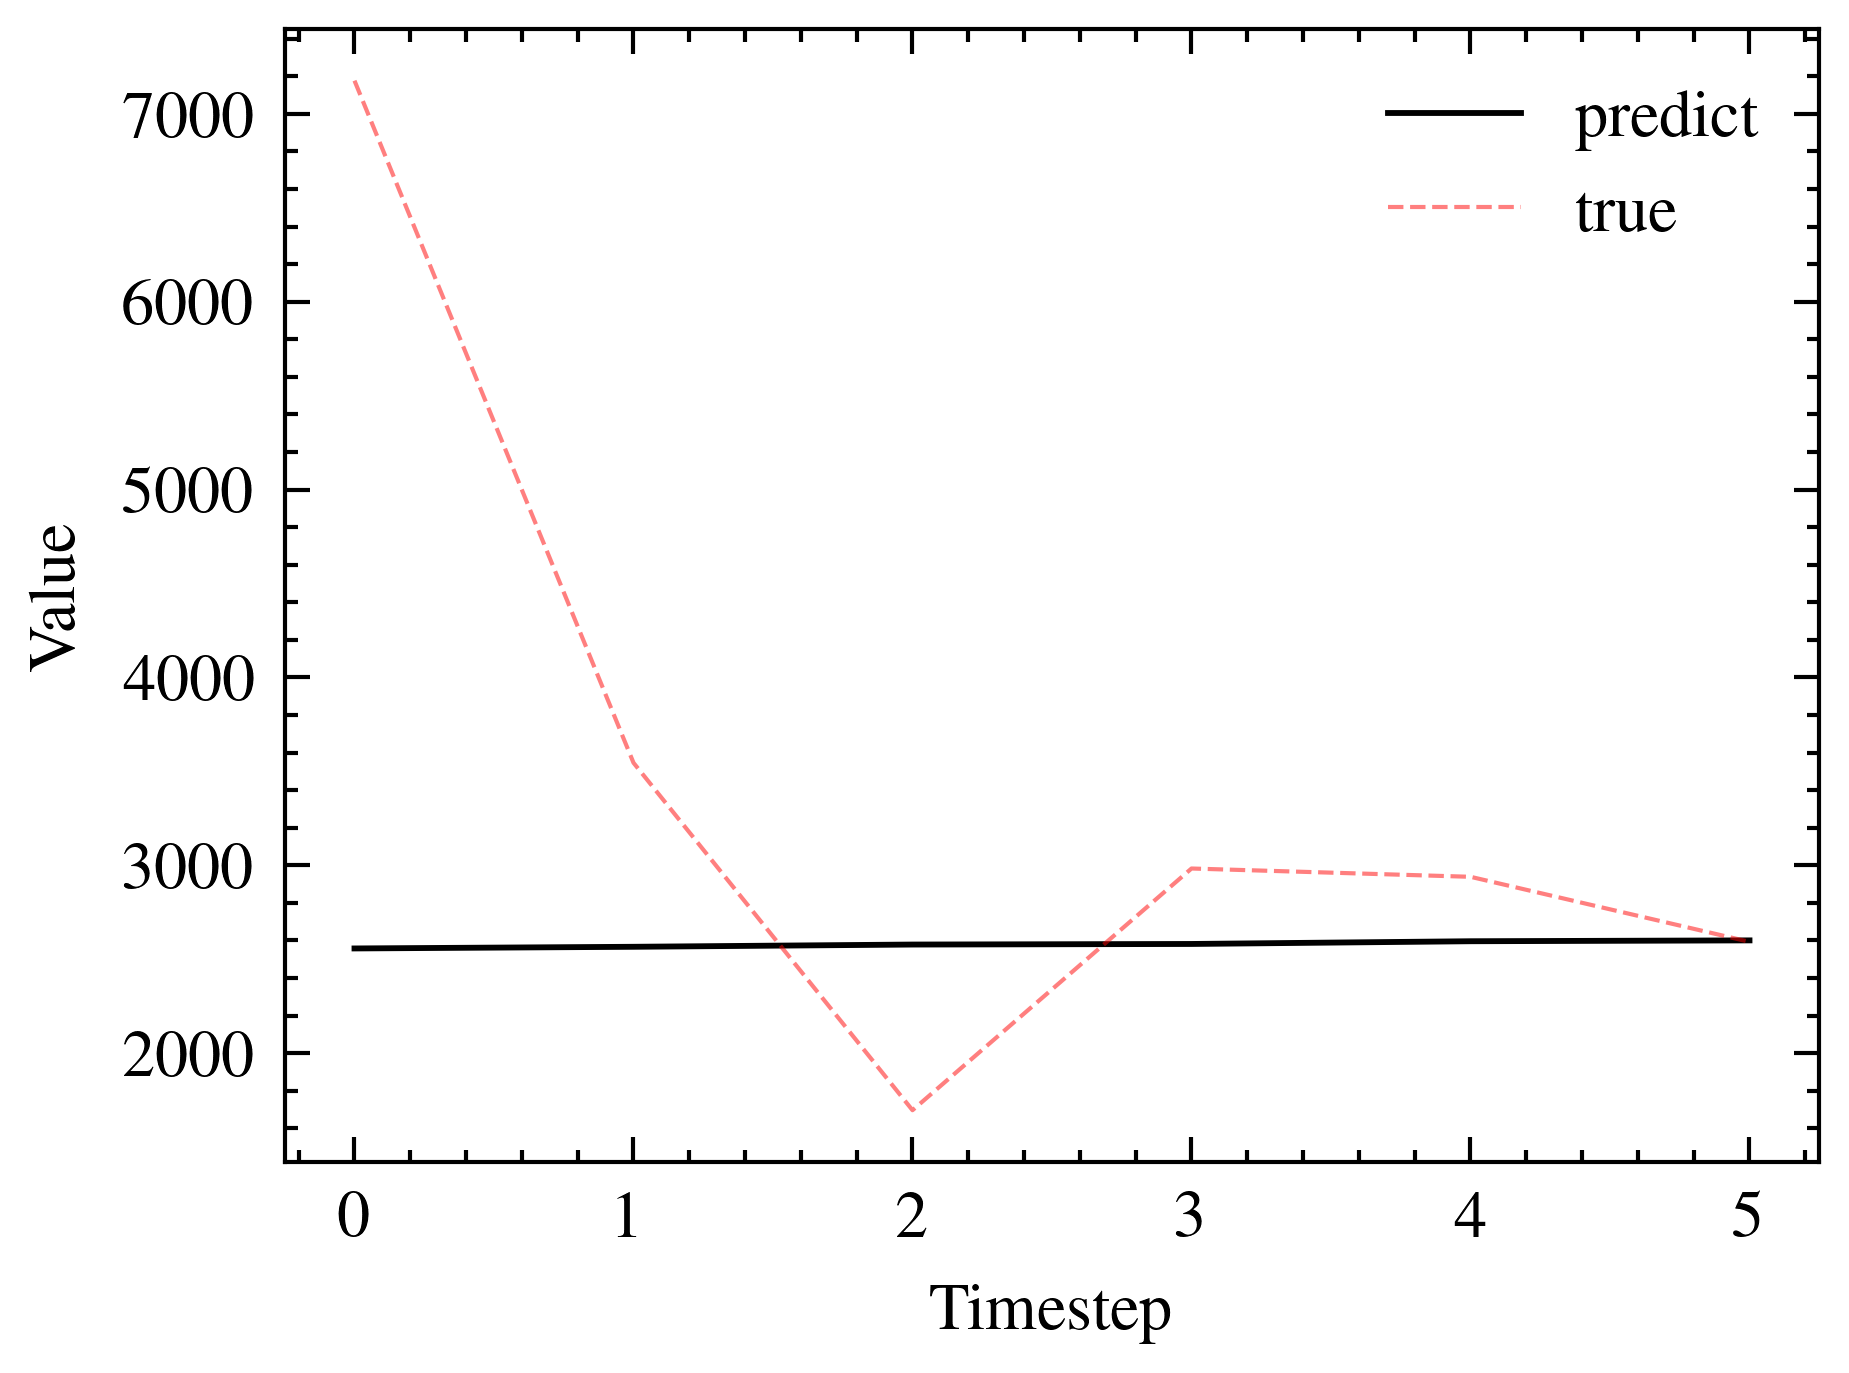

In [26]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels.reshape((-1, 1)))
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()